In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv("glrl-hab-data.csv", index_col = 0)

In [14]:
df = df[df['particulate_microcystin'] < 15]
df

,station_name,timestamp,lat,lon,particulate_microcystin,extracted_chla,dissolved_microcystin
0,WE2,2012-05-15 10:40:00,41.012700,-83.005500,0.01,3.67,NaN
1,WE4,2012-05-15 10:08:00,41.826700,-83.193300,0.01,3.05,NaN
2,WE6,2012-05-15 11:02:00,41.705200,-83.385300,0.01,2.24,NaN
3,WE8,2012-05-15 11:31:00,41.833900,-83.364000,0.01,5.73,NaN
4,WE2,2012-05-31 11:15:00,41.762500,-83.328600,0.01,6.07,NaN
...,...,...,...,...,...,...,...
1762,WE8,2025-05-19 08:15:00,41.834050,-83.358550,0.01,3.30,NaN
1763,WE9,2025-05-19 11:58:00,41.717683,-83.422950,0.01,75.62,NaN
1764,WE12,2025-05-19 10:53:00,41.703300,-83.252417,0.01,11.05,NaN
1765,WE13,2025-05-19 09:41:00,41.742967,-83.136817,0.01,11.07,NaN


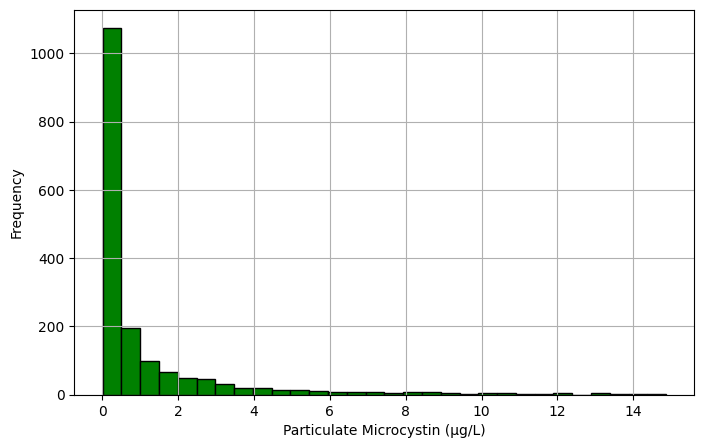

Count of particulate_microcystin values >= 5: 110
Count of particulate_microcystin values >= 10: 33


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is called df
# Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(df['particulate_microcystin'].dropna(), bins=30, color = "green", edgecolor='black')
plt.xlabel('Particulate Microcystin (µg/L)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Count how many values are >= 5 and >= 10
count_5_or_above = (df['particulate_microcystin'] >= 5).sum()
count_10_or_above = (df['particulate_microcystin'] >= 10).sum()

print(f"Count of particulate_microcystin values >= 5: {count_5_or_above}")
print(f"Count of particulate_microcystin values >= 10: {count_10_or_above}")


In [14]:
training_data_filename = "Grid_search_oversample/3day_5px_0.1pm/training_data_balanced_PACE.npy"

Loaded 290 entries from Grid_search_oversample/3day_5px_0.1pm/training_data_balanced_PACE.npy
First entry tuple length: 4
Tuple contents/types: [<class 'str'>, <class 'str'>, <class 'tuple'>, <class 'numpy.ndarray'>]
Lengths/shapes of elements:
  Element 0: PACE_OCI.20240902T180931.L2.OC_AOP.V3_0.nc (type <class 'str'>)
  Element 1: 2024.2 (type <class 'str'>)
  Element 2: ('2024.2', Timestamp('2024-09-02 18:09:31+0000', tz='UTC'), 41.71703333, -83.41671667, 30.28, 0.43, 481.58) (type <class 'tuple'>)
  Element 3: numpy array with shape (4300,)
patch_flat length: 4300


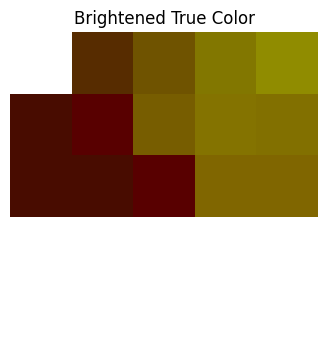

In [15]:
# Load the training data
try:
    data = np.load(training_data_filename, allow_pickle=True)
    print(f"Loaded {len(data)} entries from {training_data_filename}")
except FileNotFoundError:
    raise FileNotFoundError(f"{training_data_filename} not found in the current directory.")

# Inspect first entry to understand tuple structure
first_entry = data[60]
print(f"First entry tuple length: {len(first_entry)}")
print(f"Tuple contents/types: {[type(x) for x in first_entry]}")
print(f"Lengths/shapes of elements:")
for idx, elem in enumerate(first_entry):
    if isinstance(elem, np.ndarray):
        print(f"  Element {idx}: numpy array with shape {elem.shape}")
    else:
        try:
            print(f"  Element {idx}: {elem} (type {type(elem)})")
        except:
            print(f"  Element {idx}: type {type(elem)}")

# Assume structure is (row_index, labels_array, patch_flat_array)
# Adjust these indices if different.
patch_flat = first_entry[3]
print(f"patch_flat length: {patch_flat.size}")

# Example inference (only if patch is square and c known):
c = 172
spatial_pixels = patch_flat.size // c
if spatial_pixels * c != patch_flat.size:
    raise ValueError("Flat size not divisible by c; adjust c or patch shape.")
side = int(np.sqrt(spatial_pixels))
if side * side != spatial_pixels:
    raise ValueError("Spatial dimension not square; set h and w manually.")
h, w = side, side

# Ensure patch_flat can reshape to (h, w, c)
if h is None or w is None or c is None:
    raise ValueError("Please set h, w, c to the correct patch dimensions before plotting.")

if patch_flat.size != h * w * c:
    raise ValueError(f"patch_flat size {patch_flat.size} does not match h*w*c = {h*w*c}")

# Reshape and plot RGB for the first entry
patch = patch_flat.reshape((h, w, c))

red_idx = 105
green_idx = 75
blue_idx = 48 

# after reshaping patch_flat → patch (h, w, c) and selecting R,G,B indices:
red = patch[:,:,red_idx]
green = patch[:,:,green_idx]
blue = patch[:,:,blue_idx]
rgb = np.stack([red, green, blue], axis=-1)  # reflectance array

# Normalize using fixed vmax:
vmax = 0.05  # adjust if your scene reflectance peaks lower/higher
rgb_norm = rgb / vmax
rgb_norm = np.clip(rgb_norm, 0, 1)

# Apply gamma correction:
gamma = 1/2.2  # or 1/1.5 for more brightness
rgb_plot = np.clip(rgb_norm ** gamma, 0, 1)

plt.figure(figsize=(4,4))
plt.imshow(rgb_plot, origin='lower')
plt.axis('off')
plt.title("Brightened True Color")
plt.show()

In [ ]:
training_data_filename = "Grid_search3/3day_3px_1pm/training_data_PACE.npy"
# Load the training data
try:
    data = np.load(training_data_filename, allow_pickle=True)
    print(f"Loaded {len(data)} entries from {training_data_filename}")
except FileNotFoundError:
    raise FileNotFoundError(f"{training_data_filename} not found in the current directory.")

# Inspect first entry to understand tuple structure
first_entry = data[0]
print(f"First entry tuple length: {len(first_entry)}")
print(f"Tuple contents/types: {[type(x) for x in first_entry]}")
print(f"Lengths/shapes of elements:")
for idx, elem in enumerate(first_entry):
    if isinstance(elem, np.ndarray):
        print(f"  Element {idx}: numpy array with shape {elem.shape}")
    else:
        try:
            print(f"  Element {idx}: {elem} (type {type(elem)})")
        except:
            print(f"  Element {idx}: type {type(elem)}")

# Assume structure is (row_index, labels_array, patch_flat_array)
# Adjust these indices if different.
patch_flat = first_entry[3]
print(f"patch_flat length: {patch_flat.size}")

# Example inference (only if patch is square and c known):
c = 172
spatial_pixels = patch_flat.size // c
if spatial_pixels * c != patch_flat.size:
    raise ValueError("Flat size not divisible by c; adjust c or patch shape.")
side = int(np.sqrt(spatial_pixels))
if side * side != spatial_pixels:
    raise ValueError("Spatial dimension not square; set h and w manually.")
h, w = side, side

# Ensure patch_flat can reshape to (h, w, c)
if h is None or w is None or c is None:
    raise ValueError("Please set h, w, c to the correct patch dimensions before plotting.")

if patch_flat.size != h * w * c:
    raise ValueError(f"patch_flat size {patch_flat.size} does not match h*w*c = {h*w*c}")

# Reshape and plot RGB for the first entry
patch = patch_flat.reshape((h, w, c))

red_idx = 105
green_idx = 75
blue_idx = 48 

# after reshaping patch_flat → patch (h, w, c) and selecting R,G,B indices:
red = patch[:,:,red_idx]
green = patch[:,:,green_idx]
blue = patch[:,:,blue_idx]
rgb = np.stack([red, green, blue], axis=-1)  # reflectance array

# Normalize using fixed vmax:
vmax = 0.05  # adjust if your scene reflectance peaks lower/higher
rgb_norm = rgb / vmax
rgb_norm = np.clip(rgb_norm, 0, 1)

# Apply gamma correction:
gamma = 1/2.2  # or 1/1.5 for more brightness
rgb_plot = np.clip(rgb_norm ** gamma, 0, 1)

plt.figure(figsize=(4,4))
plt.imshow(rgb_plot, origin='lower')
plt.axis('off')
plt.title("Brightened True Color")
plt.show()

In [ ]:
for entry in data:
    patch_len = len(entry[3])
    print(patch_len)

In [ ]:
len(data)

In [ ]:
dates = []
for entry in data:
    dates.append(pd.to_datetime(entry[2][1], utc = True))
dates

In [ ]:
import matplotlib.dates as mdates

date_counts = pd.Series(dates).value_counts().sort_index()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(date_counts.index, date_counts.values, width=0.9)

# Format the x-axis
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # tick every 7 days
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # format tick labels
plt.xticks(rotation=45)

ax.set_xlabel("Date")
ax.set_ylabel("Count")
ax.set_title("Histogram of Timestamps by Day")
plt.tight_layout()
plt.show()

In [ ]:
df.head(10)

In [ ]:
# 1. Subset to only include timestamps from 2024 and onward
df_recent = df[df['timestamp'] >= pd.Timestamp('2024-01-01')].copy()

# 2. Normalize to date (for grouping by day)
df_recent['date'] = df_recent['timestamp'].dt.normalize()

# 3. Count samples per day
daily_counts = df_recent['date'].value_counts().sort_index()

# 4. Plot the histogram
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(daily_counts.index, daily_counts.values, width=2.9)

# Format x-axis to show one tick every 7 days
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Labels
ax.set_xlabel("Date")
ax.set_ylabel("Sample Count")
ax.set_title("Number of Samples per Day (2024 and After)")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

df['timestamp'] = pd.to_datetime(df['timestamp'])
# Filter to 2024-06-01 through 2024-10-15
df_plot = df[(df['timestamp'] >= pd.Timestamp('2024-06-01')) & 
             (df['timestamp'] <= pd.Timestamp('2024-10-20'))].copy()

# Filter out non-positive values
df_plot = df_plot[df_plot['particulate_microcystin'] > 0].copy()

# Compute log10
df_plot['log_particulate_microcystin'] = np.log10(df_plot['particulate_microcystin'])

# Create scatter plot with increased height
fig, ax = plt.subplots(figsize=(10, 8))  # 3x taller

ax.scatter(
    df_plot['timestamp'],
    df_plot['log_particulate_microcystin'],
    color='blue',
    s=10,
    alpha=0.7
)

# Set y-axis range to -1 to 1
ax.set_ylim(-2, 1)

# Format x-axis
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Add horizontal lines at integer log levels (only -1, 0, 1)
for y in range(-1, 2):  # -1, 0, 1
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.5, alpha=0.6)

# Labels
ax.set_xlabel("Date")
ax.set_ylabel("log₁₀(Particulate Microcystin)")
ax.set_title("Scatter Plot of log₁₀ Particulate Microcystin (2024-06 to 2024-10)")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract date only
df['date'] = df['timestamp'].dt.normalize()

# Filter to 2024 and desired date range (June 19 to Oct 10)
df_filtered = df[
    (df['timestamp'].dt.year == 2024) &
    (df['timestamp'].dt.month * 100 + df['timestamp'].dt.day >= 600) &
    (df['timestamp'].dt.month * 100 + df['timestamp'].dt.day <= 1100)
]

# Drop rows where particulate_microcystin is <= 0 (log undefined)
df_filtered = df_filtered[df_filtered['particulate_microcystin'] > 0].copy()

# Take log10
df_filtered['log_particulate_microcystin'] = np.log10(df_filtered['particulate_microcystin'])

# Group into list of log-values per date
grouped = df_filtered.groupby('date')['log_particulate_microcystin'].apply(list)

# Convert to lists for plotting
dates = grouped.index
data = grouped.values

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.boxplot(data, positions=range(len(dates)), widths=0.6, showfliers=True)

# Format x-axis
ax.set_xticks(range(len(dates)))
ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in dates], rotation=45, ha='right')
ax.set_xlabel("Date")
ax.set_ylabel("Log10 Particulate Microcystin")
ax.set_title("Daily Boxplots (log10) of Particulate Microcystin (2024-06-19 to 2024-10-10)")

plt.tight_layout()
plt.show()


In [ ]:
np.save('training_data_PACE.npy', np.array(data, dtype=object))

In [ ]:
i = 0
for entry in data:
    
    for j in range(i, len(df)):
        
        labels = entry[2]
        print(j)
        print(pd.to_datetime(labels[1], utc = True))
        print(pd.to_datetime(df.loc[j, 'timestamp'], utc = True))
        print()
        if labels[0] == df.loc[j, 'station_name'] and \
            pd.to_datetime(labels[1], utc = True) == pd.to_datetime(df.loc[j, 'timestamp'], utc = True):
                print("FOUND ONE")
                labels = (labels[0], labels[1], labels[2], labels[3], labels[4], df.loc[j, 'dissolved_microcystin'], labels[5])
                i = j
                break

In [ ]:
len(data[0][3])

In [ ]:
import numpy as np

def crop_and_clean_array(data):
    cleaned_entries = []

    for entry in data:
        granule_name, site_code, metadata, patch = entry

        if patch.size == 4300:  # 8x8x11
            patch_3d = patch.reshape(5, 5, 172)
            # Crop center 2x2 pixels (from rows 3:5, cols 3:5)
            cropped = patch_3d[1:3, 1:3, :]  # shape (2, 2, 11)
            reshaped = cropped.reshape(-1)  # Flatten to (44,)

            # Check NaN status per pixel
            pixel_nans = np.isnan(cropped.reshape(1, 172))  # (4, 11)
            pixel_all_nan = np.all(pixel_nans, axis=1)     # (4,)

            if np.sum(~pixel_all_nan) >= 1:
                cleaned_entries.append([granule_name, site_code, metadata, reshaped])

        elif patch.size == 1548:  # already 2x2x11
            reshaped = patch.reshape(9, 172)
            pixel_all_nan = np.all(np.isnan(reshaped), axis=1)

            if np.sum(~pixel_all_nan) >= 2:
                cleaned_entries.append(entry)

        else:
            print(f"Skipping entry with unexpected patch size: {patch.size}")

    return np.array(cleaned_entries, dtype=object)


In [ ]:
data = crop_and_clean_array(data)
len(data)

In [ ]:
len(data)

In [ ]:
def average_patch_pixels(data):
    final_entries = []

    for entry in data:
        granule_name, site_code, metadata, patch = entry

        try:
            reshaped = patch.reshape(4, 11)  # 2x2 pixels, 11 channels
            mean_pixel = np.nanmean(reshaped, axis=0)  # shape (11,)
            final_entries.append([granule_name, site_code, metadata, mean_pixel])
        except Exception as e:
            print(f"Failed to process entry {granule_name}: {e}")

    return np.array(final_entries, dtype=object)
data = average_patch_pixels(data)

In [ ]:
np.save(f'training_data_PACE_cropped', np.array(data, dtype=object))

In [ ]:
# Extract labels arrays, replacing NaN with 0
partic_list = []
for entry in data:
    labels = entry[2]  # (particulate)
    if labels is not None and len(labels) >= 2:
        partic_val = labels[4] if not np.isnan(labels[4]) else 0.01
        if partic_val == 0: partic_val = 0.01
        partic_list.append(partic_val)

partic = np.array(partic_list, dtype=float)

# Only values > 0
partic_positive = partic[partic > -1]

print(f"Particulate: total={len(partic)}, >0 count={len(partic_positive)}")

# 1) Histogram with log-scaled x-axis and log-spaced bins
def plot_log_histogram(values, title):
    # Determine bin edges in log space
    min_val = values.min()
    max_val = values.max()
    # Avoid issues if min_val is 0 (we have filtered >0)
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)
    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=bins)
    plt.xscale('log')
    plt.title(title + " (log-scaled bins)")
    plt.xlabel("Value (log scale)")
    plt.ylabel("Count")
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.show()

# 2) Histogram of log-transformed values (linear bins on log values)
def plot_hist_log_transformed(values, title):
    log_vals = np.log10(values)
    plt.figure(figsize=(6, 4))
    plt.hist(log_vals, bins=30)
    plt.title(title + " (histogram of log10(values))")
    plt.xlabel("log10(Value)")
    plt.ylabel("Count")
    plt.grid(True, ls='--', alpha=0.5)
    plt.show()

# 3) Boxplot of log-transformed values
def plot_boxplot_log(values, title):
    log_vals = np.log10(values)
    plt.figure(figsize=(4, 6))
    plt.boxplot(log_vals, vert=True)
    plt.title(title + " (boxplot of log10(values))")
    plt.ylabel("log10(Value)")
    plt.grid(True, ls='--', alpha=0.5)
    plt.show()

# 4) Empirical CDF (on log scale)
def plot_ecdf(values, title):
    sorted_vals = np.sort(values)
    n = len(sorted_vals)
    ecdf = np.arange(1, n + 1) / n
    plt.figure(figsize=(6, 4))
    plt.plot(sorted_vals, ecdf)
    plt.xscale('log')
    plt.title(title + " CDF (x-axis log scale)")
    plt.xlabel("Value (log scale)")
    plt.ylabel("ECDF")
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.show()

# Plot for particulate_microcystin > 0
plot_log_histogram(partic_positive, "Particulate Microcystin")
plot_hist_log_transformed(partic_positive, "Particulate Microcystin")
plot_boxplot_log(partic_positive, "Particulate Microcystin")
plot_ecdf(partic_positive, "Particulate Microcystin")

In [ ]:
df.head(2)

In [ ]:
earliest = pd.to_datetime("2025-1-1", utc = True)

for i in range(len(data)):
    labels = data[i][2]
    date = pd.to_datetime(labels[1], utc = True)
    if date < earliest: 
        print(f"{i} - {date} earlier than {earliest}")
        earliest = date

print(earliest)

In [ ]:
label_dict = {}
for i in range(len(data)):
    labels = data[i][1]
    for idx, row in df.iterrows():
        if pd.to_datetime(labels[1]) == pd.to_datetime(row.get("timestamp")) and \
            labels[2] == row.get("lat") and \
            labels[3] == row.get("lon"):
                label_dict[i] = idx

In [ ]:
label_dict

In [ ]:
total = 0
for i in range(len(df)):
    if i not in label_dict.values():
        total = total + 1

print(total)

In [ ]:
len(df) - total

In [ ]:
len(data)

In [ ]:
from collections import Counter
value_counts = Counter(label_dict.values())
print(value_counts)

In [ ]:
df.station_name.unique()

In [ ]:
df